In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 274 kB 7.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=fb9fd87fb85f948e39ed4c0d2ba418e1415d30273fd540258f24f8354ac8d8d3
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.9.0+cu102 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-4qqufe9h
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-4qqufe9h
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=64542 sha256=5638241133fe20def06182434d4540db00aac1b045337494efcc0133e2ed7d67
  Stored in directory: /tmp/pip-ephem-wheel-cache-mxzswpex/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
Successfully built fvcore
Cloning into 'detectron2_repo'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (443/443), done.
remote: Compressing objects: 100% (262/262), done.
remote: Total 12942 (delta 231), reused 340 (delta 177), pack-reused 12499
Receiving objects: 100% (12942/12942), 5.56 MiB | 17.89 MiB/s, done.
Resolving deltas: 100% (9179/9179), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 145 k

In [ ]:
!unzip "/content/drive/MyDrive/ocr.zip" -d "/content/"

Archive:  /content/drive/MyDrive/ocr.zip
  inflating: /content/ocr/trainval.json  
   creating: /content/ocr/trial1/
  inflating: /content/ocr/trial1/1.jpeg  
  inflating: /content/ocr/trial1/1.json  


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
def configuration_model():
    cfg = get_cfg()
    cfg.merge_from_file("detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

    cfg.DATALOADER.NUM_WORKERS = 2

    cfg.SOLVER.IMS_PER_BATCH = 2

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    cfg.MODEL.DEVICE = 'cuda'

    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  # set a custom testing threshold

    cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/diesease/model_final.pth'
    predictor = DefaultPredictor(cfg)
    return predictor

In [ ]:
predict = configuration_model()

In [ ]:
im = cv2.imread("/content/drive/MyDrive/microscopic/mi/cancercell.jpg")
outputs1 = predict(im)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

846 542
Value of N
60


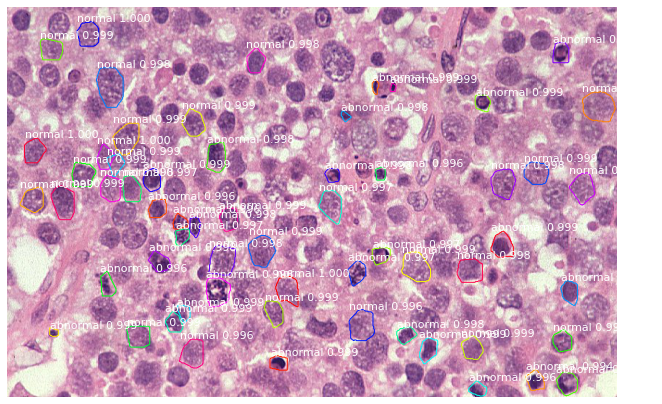

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import colorsys
import numpy as np
import os, json, cv2, random
from skimage.measure import find_contours as fc
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon as p
from matplotlib.patches import Polygon
img="/content/drive/MyDrive/microscopic/mi/cancercell.jpg"
imm = Image.open(img)
#class_names = ['broken','dent','grill','light','other','peeloff','scratch']
class_names = ['abnormal','normal']

pred_class = outputs1["instances"].pred_classes.cpu().numpy()
pred_score = outputs1["instances"].scores.cpu().numpy()
pred_box = outputs1["instances"].pred_boxes.tensor.cpu().numpy()
pred_mask_dent = outputs1["instances"].pred_masks.cpu().numpy()
fig = plt.figure(frameon=False)
w, h = imm.size
print(w, h)
fig.set_size_inches(w / 100, h / 100)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(imm, aspect='auto')
length_of_pred_class = len(pred_class)
print("Value of N")
print(length_of_pred_class)
colors = random_colors(length_of_pred_class)
pol_list=[]
if length_of_pred_class != 0:
    for i in range(length_of_pred_class):
            color = colors[i]
            class_id = pred_class[i]
            score = pred_score[i]
            label = class_names[class_id]
            x1, y1, x2, y2 = pred_box[i]
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
            ax.text(x1, y1, caption, color='w', size=11, backgroundcolor="none")
            mask = pred_mask_dent[i]
            p_m = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
            p_m[1:-1, 1:-1] = mask
            con = fc(p_m, 0.5)
            for verts in con:
                polCen = None
                verts = np.fliplr(verts) - 1
                pol_cor = p(verts)
                poly_plot = Polygon(verts, edgecolor=color, facecolor='none')
                polCen = [pol_cor.centroid.x, pol_cor.centroid.y]
                pol_list.append(polCen)
                ax.add_patch(poly_plot)

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("car", {}, "/content/drive/MyDrive/microscopic/trainval.json", "/content/drive/MyDrive/microscopic/mi")

In [ ]:
fruits_nuts_metadata = MetadataCatalog.get("car")

In [ ]:
fruits_nuts_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/MyDrive/microscopic/mi', json_file='/content/drive/MyDrive/microscopic/trainval.json', name='car')

In [ ]:
dataset_dicts = DatasetCatalog.get("car")

WARNING [08/27 16:46:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/27 16:46:03 d2.data.datasets.coco]: Loaded 1 images in COCO format from /content/drive/MyDrive/microscopic/trainval.json


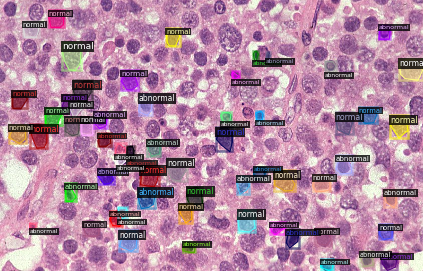

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruits_nuts_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os
print("%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%")

cfg = get_cfg()
cfg.merge_from_file(
    "./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.DATASETS.TRAIN = ("car",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = (
     3000
)  # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
[08/30 05:41:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, 

model_final_f10217.pkl: 178MB [00:03, 56.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (58, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (58,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (228, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (228,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model du

[08/30 05:42:04 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[08/30 05:42:18 d2.utils.events]:  eta: 1:49:39  iter: 19  total_loss: 5.249  loss_cls: 3.672  loss_box_reg: 0.2759  loss_mask: 0.6921  loss_rpn_cls: 0.5795  loss_rpn_loc: 0.3407  time: 0.6783  data_time: 0.0611  lr: 0.00019981  max_mem: 4797M
[08/30 05:42:32 d2.utils.events]:  eta: 1:50:18  iter: 39  total_loss: 3.112  loss_cls: 1.6  loss_box_reg: 0.3682  loss_mask: 0.6851  loss_rpn_cls: 0.18  loss_rpn_loc: 0.2595  time: 0.6768  data_time: 0.0258  lr: 0.00039961  max_mem: 4797M
[08/30 05:42:46 d2.utils.events]:  eta: 1:51:01  iter: 59  total_loss: 2.639  loss_cls: 1.283  loss_box_reg: 0.3166  loss_mask: 0.6688  loss_rpn_cls: 0.1145  loss_rpn_loc: 0.2337  time: 0.6792  data_time: 0.0280  lr: 0.00059941  max_mem: 4797M
[08/30 05:43:00 d2.utils.events]:  eta: 1:51:45  iter: 79  total_loss: 2.438  loss_cls: 1.184  loss_box_reg: 0.3119  loss_mask: 0.6353  loss_rpn_cls: 0.08681  loss_rpn_loc: 0.2106  time: 0.6837  data_time: 0.0248  lr: 0.00079921  max_mem: 4797M
[08/30 05:43:13 d2.utils.ev

In [ ]:
!cp /content/output/model_final.pth "/content/drive/MyDrive/diesease"

In [ ]:
!cp /content/output/model_final.pth "/content/drive/MyDrive/ocr"

In [ ]:
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3  ##** set the testing threshold for this model
cfg.DATASETS.TEST = ("car", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode

In [ ]:
outputs

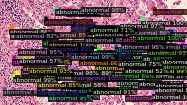

In [ ]:
im = cv2.imread("/content/drive/MyDrive/microscopic/download.jpg")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
      metadata=fruits_nuts_metadata, 
                   scale=0.3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
im = cv2.imread("/content/download.png")
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
      metadata=fruits_nuts_metadata, 
                   scale=0.2, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output